<a href="https://colab.research.google.com/github/ad71/ragbot/blob/master/langchain_agent_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


Here we will build reliable RAG agents using LangGraph, Groq-Llama-3 and Chroma.
We will combine the below concepts to build the RAG Agent.

1. Adaptive RAG: We have implemented the concept described in this paper build a Router for routing questions to different retrieval approaches

2. Corrective RAG: We have implemented the concept described in this paper to develop a fallback mechanism to progress with when the context retrieved is irrelevant to the question asked.

3. Self-RAG: We have implemented the concept described in this paper to develop a hallucination grader ie fix answers that hallucinate or doesn't address the questions asked

## What is an Agent?
The fundamental concept behind agents involves employing a language model to select a sequence of actions. While in chains, this sequence is hardcoded within the code. Conversely, agents utilize a language model as a reasoning engine to decide the actions to take and their order.

It comprises of 3 components:
1. planning: breaking the tasks into smaller sub-goals
2. memory: short term (chat-history) / long term (vectorstore)
3. tool use: it can make use of different tools to extend its capabilities

Agents can be manifested using ReAct concept with LangChain or by using LangGraph.
Tradeoffs:

- **Reliability**
    1. ReAct/LangChain Agent: Less reliable, as LLM has to make the correct decision at each step.
    2. LangGraph: More reliable, as control flow is set and LLM has a specific job to perform at each node.

- **Flexibility**
    1. ReAct/LangChain Agent: More flexible as LLM can choose any sequence of actions.
    2. LangGraph: Less flexible as actions are constrained by setting up the control flow at each node.

- **Compatiblity with smaller LLMs**
    1. ReAct/LangChain Agent: Worse compatiblity
    2. LangGraph: Better Compatiblity


## LangChain:
Framework for developing applications powered by language models. It enables applications that:
1. Are context-aware: connect a language model to sources of context (prompt instructions, few shot examples, content to ground its response in, etc)
2. Reason: rely on a language model to reason (about how to answer based on provided context, what actions to take, etc)

## LangGraph:
LangGraph is a library that extends LangChain, providing cyclic computational capabilities for LLM applications. While LangChain supports defining computation chains (Directed Acyclic Graphs or DAGs), **LangGraph enables the incorporation of cycles**. This allows for more intricate, agent-like behaviours, where an LLM can be called in a loop to determine the next action to take.

### Key concepts:
1. Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in our computation, and the graph maintains a state that is passed around and updated as the computation progresses.
2. Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. We define nodes to perform specific tasks, such as processing input, making decisions, or interacting with external APIs.
3. Edges: Edges connect the nodes in your graph, defining the flow of computation. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph.

### Steps involved in creating a graph using LangGraph
1. Define the graph state: This represents the state of the graph
2. Create the graph
3. Define the nodes: here we define the different functions associated with each workflow state
4. Add nodes to the graph: here add our nodes to the graph and define the flow using edges and conditional edges
5. Set entry and end points of the graph

### Tavily search API
Tavily search API is a search engine optimized for LLMs, aimed at efficient, quick and persistent search results. Unlike other search APIs such as Serp or Google, Tavily focuses on optimizing search for AI developers and autonomous AI agents.
### Groq
Groq offers high-performance AI models & API access for developers with faster inference and at lower cost than competitors
### FastEmbed
FastEmbed is a lightweight, fast, Python library built for embedding generation.

## Workflow of the RAG Agent

1. Based on the question, the router decides whether to direct the question to retrieve the context from vectorstore or perform a web search
2. If the router decides the question has to be directed for retrieval from vectorstore, then matching documents are retrieved from the vectorstore otherwise perform a web search using tavily-api search
3. The document grader then grades the documents as relevant or irrelevant
4. If the context retrieved is graded as relevant then check for hallucination using the hallucination grader. If the grader decides the response to be devoid of hallucination the present the response to the user.
5. In case the context is graded as irrelevant then perform a web search to retrieve the content.
6. Post retrieval, the document grader grades the content generated from web search. If found relevant the response is synthesized by using LLM and then presented.


## Technology stack used
- Embedding model: BAAI/bge-base-en-v1.5
- LLM: Llama3-8B
- Vectorstore: Chroma
- Graph/Agent: LangGraph

# Implementation

In [ ]:
%pip install langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python gpt4all fastembed langchain-groq grandalf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

In [ ]:
embed_model = FastEmbedEmbeddings(model_name='BAAI/bge-base-en-v1.5')

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

In [ ]:
from groq import Groq
from langchain_groq import ChatGroq
from google.colab import userdata

llm = ChatGroq(temperature=0, model_name='Llama3-8b-8192', api_key=userdata.get('GROQ_API_KEY'))

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(f'len of documents: {len(docs_list)}')

len of documents: 3


In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=512, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)
print(f'length of document chunks generated: {len(doc_splits)}')

length of document chunks generated: 87


In [ ]:
# load the documents to vectorstore
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embed_model, collection_name='local-rag')

In [ ]:
# instantiate retriever
retriever = vectorstore.as_retriever(search_kwargs={'k': 2})

In [ ]:
# implement the router
import time
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template='''<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a user question
    to a vectorstore or web search. Use the vectorstore for questions on LLM agents, prompt engineering, and adversarial
    attacks. You do not need to be stringent with the keywords in the questions related to these topics. Otherwise, use
    web-search. Give a binary choice 'web_search' or 'vectorstore' based on the question. Return the JSON with a single
    key 'datasource' and no preamble or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>''',
    input_variables=['question']
)

start = time.time()
question_router = prompt | llm | JsonOutputParser()

question = 'llm agent memory'
print(question_router.invoke({'question': question}))
end = time.time()
print(f'The time required to generate response by Router Chain in seconds: {end - start}')

{'datasource': 'web_search'}
The time required to generate response by Router Chain in seconds: 0.627485990524292


In [ ]:
# implement the generate chain
prompt = PromptTemplate(
    template='''<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>''',
    input_variables=['question', 'document']
)

# post-processing
def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

# chain
start = time.time()
rag_chain = prompt | llm | StrOutputParser()

question = 'agent memory'
docs = retriever.invoke(question)

generation = rag_chain.invoke({'question': 'agent memory', 'context': format_docs(docs)})
end = time.time()
print(f'The time required to generate response by Router Chain in seconds: {end - start}')
print(generation)

The time required to generate response by Router Chain in seconds: 0.9210071563720703
The concept of agent memory is discussed in the context of LLM-powered autonomous agents, where the authors highlight the challenges of long-term planning and task decomposition due to the limited context capacity. The article mentions the importance of self-reflection and learning from past mistakes, but does not provide specific details on the agent's memory architecture.


In [ ]:
# implement retrieval grader
prompt = PromptTemplate(
    template='''<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user's question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals.

    Give a binary 'yes' or 'no' score to indicate whether the document is relevant to the question

    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    ''',
    input_variables=['question', 'document']
)

start = time.time()
retrieval_grader = prompt | llm | JsonOutputParser()
question = 'agent memory'
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({'question': question, 'document': doc_txt}))
end = time.time()
print(f'The time required to generate response by the retrieval grader in seconds: {end - start}')

{'score': 'yes'}
The time required to generate response by the retrieval grader in seconds: 0.5024116039276123


In [ ]:
# Implement the hallucination grader
prompt = PromptTemplate(
    template='''<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:

    ------------------

    {documents}

    ------------------

    Here is the answer: {generation} <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    ''',
    input_variables=['generation', 'documents']
)

start = time.time()
hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader_response = hallucination_grader.invoke({'documents': docs, 'generation': generation})
end = time.time()

print(f'The time required to generate response by the generation chain in seconds: {end - start}')
print(hallucination_grader_response)

The time required to generate response by the generation chain in seconds: 0.45027780532836914
{'score': 'yes'}


In [ ]:
# Implement the answer grader
prompt = PromptTemplate(
    template='''<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:

    ------------------

    {generation}

    ------------------

    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    ''',
    input_variables=['generation', 'question']
)

start = time.time()
answer_grader = prompt | llm | JsonOutputParser()
answer_grader_response = answer_grader.invoke({'question': question, 'generation': generation})
end = time.time()

print(f'The time required the generate response by the answer grader in seconds: {end - start}')
print(answer_grader_response)

The time required the generate response by the answer grader in seconds: 0.2574803829193115
{'score': 'yes'}


In [ ]:
# implement web search tool
import os
from langchain_community.tools.tavily_search import TavilySearchResults
os.environ['TAVILY_API_KEY'] = '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'
web_search_tool = TavilySearchResults(k=3)

Define the following attributes
- question
- generation: LLM generation
- web_search: whether to add search
- documents: list of documents

In [ ]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [ ]:
# define the nodes

from langchain.schema import Document

def retrieve(state: GraphState) -> GraphState:
    '''
    Retrieve documents from vectorstore

    Args:
        state (dict): the current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents

    '''
    print('[RETRIEVE]')
    question = state['question']

    # retrieval
    documents = retriever.invoke(question)
    return {'documents': documents, 'question': question}

def generate(state: GraphState) -> GraphState:
    '''
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    '''
    print('[GENERATE]')
    question = state['question']
    documents = state['documents']

    # RAG generation
    generation = rag_chain.invoke({'context': documents, 'question': question})
    return {'documents': documents, 'question': question, 'generation': generation}

def grade_documents(state: GraphState) -> GraphState:
    '''
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    '''
    print('[CHECK DOCUMENT RELEVANCE TO QUESTION]')
    question = state['question']
    documents = state['documents']

    filtered_docs = []
    web_search = 'No'
    for d in documents:
        score = retrieval_grader.invoke({'question': question, 'document': d.page_content})
        grade = score['score']

        # document relevant
        if grade.lower() == 'yes':
            print('[GRADE: DOCUMENT RELEVANT]')
            filtered_docs.append(d)

        # document not relevant
        else:
            print('[GRADE: DOCUMENT NOT RELEVANT]')
            # no inclusion in filtered_docs
            # set a flag to indicate we want to run web search
            web_search = 'Yes'
            continue

    return {'documents': filtered_docs, 'question': question, 'web_search': web_search}

def web_search(state: GraphState) -> GraphState:
    '''
    Web search based on the question:

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    '''
    print('[WEB SEARCH]')
    question = state['question']
    documents = state['documents']

    docs = web_search_tool.invoke({'query': question})
    web_results = '\n'.join([d['content'] for d in docs])
    web_results = Document(page_content=web_results)

    if documents is not None:
        documents.append(web_results)

    else:
        documents = [web_results]

    return {'documents': documents, 'question': question}

## Define conditional edges

In [ ]:
def route_question(state: GraphState) -> str:
    '''
    Route question to web search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    '''
    print('[ROUTE QUESTION]')
    question = state['question']
    print(question)
    source = question_router.invoke({'question': question})
    print(source)
    print(source['datasource'])

    if source['datasource'] == 'web_search':
        print('[ROUTE QUESTION TO WEB SEARCH]')
        return 'websearch'

    elif source['datasource'] == 'vectorstore':
        print('[ROUTE QUESTION TO RAG]')
        return 'vectorstore'

In [ ]:
def decide_to_generate(state: GraphState) -> str:
    '''
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    '''
    print('[ASSESS GRADED DOCUMENTS]')
    question = state['question']
    web_search = state['web_search']
    filtered_documents = state['documents']

    if web_search == 'Yes':
        # all documents have been filtered check_relevance
        # regenerate a new query
        print('[DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO THE QUESTION, INCLUDE WEB SEARCH]')
        return 'websearch'
    else:
        print('[DECISION: GENERATE]')
        return 'generate'

In [ ]:
def grade_generation_against_documents_and_question(state: GraphState) -> str:
    '''
    Determines whether the generation is grounded in the document and answers given question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    '''
    print('[CHECK HALLUCINATIONS]')
    question = state['question']
    documents = state['documents']
    generation = state['generation']

    score = hallucination_grader.invoke({'documents': documents, 'generation': generation})
    grade = score['score']

    # check hallucination
    if grade == 'yes':
        print('[DECISION: GENERATION IS GROUNDED IN DOCUMENTS]')

        # check question answering
        print('[GRADE GENERATION vs QUESTION]')
        score = answer_grader.invoke({'question': question, 'generation': generation})
        grade = score['score']

        if grade == 'yes':
            print('[DECISION: GENERATION ADDRESSES QUESTION]')
            return 'useful'

        else:
            print('[DECISION: GENERATION DOES NOT ADDRESS QUESTION]')
            return 'not useful'

    else:
        print('[DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY]')
        return 'hallucination'

## Add nodes, make graph

In [ ]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# define the nodes
workflow.add_node('websearch', web_search)
workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)

In [ ]:
workflow.set_conditional_entry_point(
    route_question,
    {
        # router output: node name
        'websearch': 'websearch',
        'vectorstore': 'retrieve'
    }
)
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {
        'websearch': 'websearch',
        'generate': 'generate'
    }
)
workflow.add_edge('websearch', 'generate')
workflow.add_conditional_edges(
    'generate',
    grade_generation_against_documents_and_question,
    {
        'hallucination': 'generate', # potential for infinite loop
        'useful': END,
        'not useful': 'websearch'
    }
)

In [ ]:
app = workflow.compile()

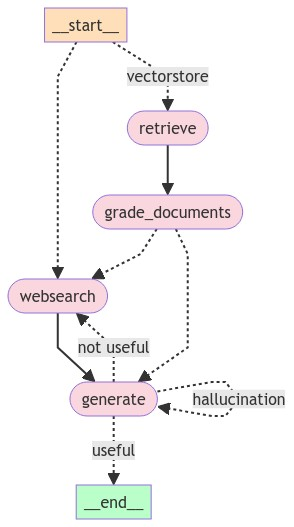

In [ ]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [ ]:
from pprint import pprint
inputs = {'question': 'What is prompt engineering?'}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f'Finished running: {key}:')

pprint(value['generation'])

[ROUTE QUESTION]
What is prompt engineering?
{'datasource': 'vectorstore'}
vectorstore
[ROUTE QUESTION TO RAG]
[RETRIEVE]
'Finished running: retrieve:'
[CHECK DOCUMENT RELEVANCE TO QUESTION]
[GRADE: DOCUMENT RELEVANT]
[GRADE: DOCUMENT NOT RELEVANT]
[ASSESS GRADED DOCUMENTS]
[DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO THE QUESTION, INCLUDE WEB SEARCH]
'Finished running: grade_documents:'
[WEB SEARCH]
'Finished running: websearch:'
[GENERATE]
[CHECK HALLUCINATIONS]
[DECISION: GENERATION IS GROUNDED IN DOCUMENTS]
[GRADE GENERATION vs QUESTION]
[DECISION: GENERATION ADDRESSES QUESTION]
'Finished running: generate:'
('Prompt engineering refers to methods for how to communicate with LLM to '
 'steer its behavior for desired outcomes without updating the model weights.')


In [ ]:
inputs = {'question': 'Which metal band has the most recent grammy?'}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f'Finished running: {key}:')

pprint(value['generation'])

[ROUTE QUESTION]
Which metal band has the most recent grammy?
{'datasource': 'web_search'}
web_search
[ROUTE QUESTION TO WEB SEARCH]
[WEB SEARCH]
'Finished running: websearch:'
[GENERATE]
[CHECK HALLUCINATIONS]
[DECISION: GENERATION IS GROUNDED IN DOCUMENTS]
[GRADE GENERATION vs QUESTION]
[DECISION: GENERATION ADDRESSES QUESTION]
'Finished running: generate:'
('Metallica has the most recent Grammy Award, winning the 2024 title of Best '
 'Metal Performance for the song "72 Seasons" from the LP of the same name.')


In [ ]:
inputs = {'question': 'What are the types of agent memory?'}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f'Finished running: {key}:')

pprint(value['generation'])

[ROUTE QUESTION]
What are the types of agent memory?
{'datasource': 'vectorstore'}
vectorstore
[ROUTE QUESTION TO RAG]
[RETRIEVE]
'Finished running: retrieve:'
[CHECK DOCUMENT RELEVANCE TO QUESTION]
[GRADE: DOCUMENT RELEVANT]
[GRADE: DOCUMENT NOT RELEVANT]
[ASSESS GRADED DOCUMENTS]
[DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO THE QUESTION, INCLUDE WEB SEARCH]
'Finished running: grade_documents:'
[WEB SEARCH]
'Finished running: websearch:'
[GENERATE]
[CHECK HALLUCINATIONS]
[DECISION: GENERATION IS GROUNDED IN DOCUMENTS]
[GRADE GENERATION vs QUESTION]
[DECISION: GENERATION DOES NOT ADDRESS QUESTION]
'Finished running: generate:'
[WEB SEARCH]
'Finished running: websearch:'
[GENERATE]
[CHECK HALLUCINATIONS]
[DECISION: GENERATION IS GROUNDED IN DOCUMENTS]
[GRADE GENERATION vs QUESTION]
[DECISION: GENERATION ADDRESSES QUESTION]
'Finished running: generate:'
('There are several types of agent memory mentioned in the context. They '
 'include:\n'
 '\n'
 '1. Sensory Memory: This is the earliest